Import / Setup

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.linalg import eigh  # to get eigenvalues
from scipy.stats import norm  # normal distribution
from scipy.misc import derivative  # autodiff

from sklearn import linear_model

rng = np.random.RandomState(0)

# Truncated Regression

In this notebook, we will study the truncated regression algorithm proposed in paper [Daskalakis, C., Gouleakis, T., Tzamos, C., & Zampetakis, M. (2019). Computationally and Statistically Efficient Truncated Regression. COLT.] which is available here: https://people.csail.mit.edu/costis/truncated-regression.pdf

As a first step, we generate data of $n_{\rm samples}$ samples based on $x \sim \mathcal{U}(0,1)$ and $y = t \cdot x + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 1)$. We take $x \in \mathbb{R}^{n_{\rm features}}$ and $y \in \mathbb{R}$.

In [2]:
n_samples, n_features = 1000, 2

x_data = rng.rand(n_samples, n_features)
t = np.array([1, 3])

y_data = np.asarray([np.matmul(t.T, x) for x in x_data]) 
y_data += rng.normal(0, 1, n_samples)

We just store this data conveniently and define some convenience variables:

In [3]:
data = np.append(x_data.T, [y_data], axis=0).T
y_min = np.min(y_data)
y_max = np.max(y_data)
one = np.ones(n_features)

The question we want to study is the following: Can we infer $t$ if we only have access to a subset of the samples, where the subset is defined by a truncation based on $y$.

We define a membership function for the truncated data based on a percentage `cutoff`

In [4]:
cutoff = 0.6  # percentage
cutoff_y = cutoff * (y_max - y_min) + y_min  # value

def truncation(p):
    """ Changing the truncation also influences the 
        survival probability below. Please check.
    """
    return cutoff < p

def membership(y):
    """ return if y is member of truncated data
    """
    p = (y - y_min) / (y_max - y_min)
    return truncation(p)

Define truncated data

In [5]:
truncated_data = data[membership(data[:, -1])]

x_trunc = truncated_data[:, :-1]
y_trunc = truncated_data[:, -1]

n_samples_trunc = len(truncated_data)

Let's plot the data and visualize its truncation:

In [6]:
l, r, n = 0, 1, 25
lin_x = np.linspace(l, r, n)
mesh_x = np.meshgrid(lin_x, lin_x)

c_plane = np.transpose([[cutoff_y for x in slice] 
                        for slice in np.transpose(mesh_x)])

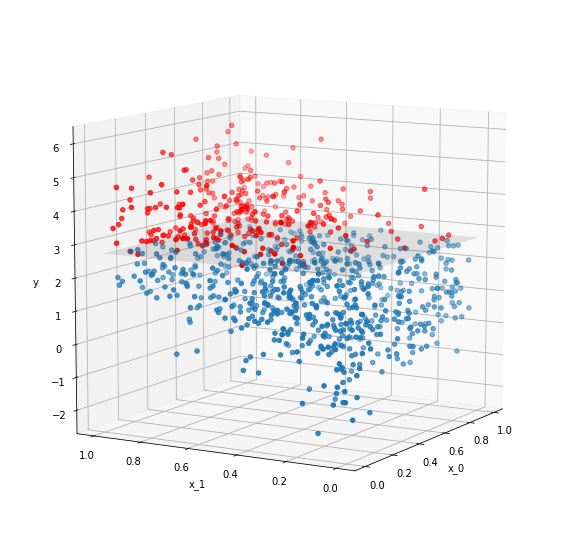

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y')
ax.view_init(10, -150)

## What's the problem?

We now want to infer $t$ from the truncated data. Clearly, if we'd just linearly regress on the truncated data, this would lead us to wrong results. To illustrate that, let's use stochastic gradient descent to fit the full data and the truncated data to a linear model $y = t \cdot x + b$

In [8]:
# Regression on full data
reg = linear_model.SGDRegressor(tol=1e-10, max_iter=10000)
reg.fit(x_data, y_data);

In [9]:
# Regression on truncated data
reg_cut = linear_model.SGDRegressor(tol=1e-10, max_iter=10000)
reg_cut.fit(x_trunc, y_trunc);

Let's again visualize it:

In [10]:
reg_surf = np.transpose([[reg.predict([x]) for x in slice] 
                         for slice in np.transpose(mesh_x)])[0]
reg_cut_surf = np.transpose([[reg_cut.predict([x]) for x in slice] 
                             for slice in np.transpose(mesh_x)])[0]

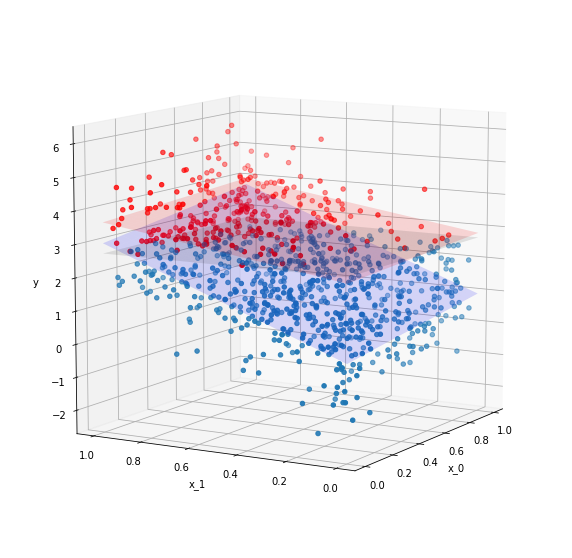

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.plot_surface(*mesh_x, reg_surf, color='b', alpha=0.15)
ax.plot_surface(*mesh_x, reg_cut_surf, color='r', alpha=0.15)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y')
ax.view_init(10, -150)

Not surprisingly, the regression on the truncated data does not generalize to the full data.

## How to solve it

Assumption 1: (CONSTANT SURVIVAL PROBABILITY ASSUMPTION): Let $(x^{(1)}, y^{(1)}), . . . , (x^{(n)}, y^{(n)})$ be samples from the truncated regression model. There exists a constant $a > 0$ such that
\begin{align}
    \sum\limits_{i = 1}^{n} \log\!\left(1/\alpha(w^* , x^{(i)})\right) \, x^{(i)} {x^{(i)}}^T
    \preccurlyeq \log(1/a) \sum\limits_{i = 1}^{n} x^{(i)} {x^{(i)}}^T
\end{align}
where $\alpha(w , x^{(i)}) = \mathcal{N}(w \cdot x^{(i)}, 1; S)$ is the survival probability of the truncated set $S$.

In [12]:
def survival_prob(w, x):
    """ survival probability
    """
    return norm(loc=np.matmul(w.T, x), scale=1).sf(cutoff_y)

def get_assumption_1_constant(x_trunc, w):
    lhs = np.sum([
        - np.log(survival_prob(w, x)) * np.outer(x, x.T)
        for i, x in enumerate(x_trunc)
    ], axis=0)
    rhs = np.sum([np.outer(x, x.T) for x in x_trunc], axis=0)
    A = np.matmul(lhs, np.linalg.inv(rhs))
    # compute largest eigenvalue
    l = eigh(A, eigvals_only=True, eigvals=(len(A)-1, len(A)-1))[-1]
    return np.exp(-l)

a = get_assumption_1_constant(x_trunc, t)
print(f'a = {a}')

a = 0.37752506152308957


Assumption 2: (THICKNESS OF COVARIANCE MATRIX OF COVARIATES ASSUMPTION) Let $X = \frac{1}{n}\sum_{i = 1}^n x^{(i)} {x^{(i)}}^T$ for $x^{(i)} \in \mathbb{R}^k$. Then for every $i \in [n]$ it holds that
\begin{align}
    X \succcurlyeq \frac{\log(k)}{n} x^{(i)} {x^{(i)}}^T
\end{align}

Theorem: Let $(x^{(1)}, y^{(1)}),\dots ,(x^{(n)}, y^{(n)})$ be $n$ samples from the truncated regression model with parameters $w$. If Assumptions 1 and 2 hold, then there exists a polynomial time algorithm with success probability at least 2/3, that outputs an estimation $\hat w$ such that
\begin{align}
\lVert \hat w - w \rVert_X \leq {\rm poly}(1/a) \sqrt{\frac{k}{n} \log(n)}
\end{align}
where $X = \frac{1}{n}\sum\limits_{i = 1}^n x^{(i)} {x^{(i)}}^T$.

We need to include a projection step into the vanilla SGD algorithm to insure that for every step the function is strongly convex over the domain, and that the variance of a random sample that approximates the gradient of said function is bounded. For that, we define the projection set
\begin{align}
D_r = \left\{ w \in \mathbb{R}^k \mid \sum\limits_{i=1}^n \left(y^{(i)} - w^T x^{(i)} \right)^2 x^{(i)} {x^{(i)}}^T \preccurlyeq r \sum\limits_{i=1}^n x^{(i)} {x^{(i)}}^T \right\}
\end{align}
We set $r^∗ = 4 \log(2/a) + 7$. Given $x \in \mathbb{R}^k$ we say that $x$ is feasible iff $x \in D_{r^*}$.

Before we define the domain function, let us define the gradient of a function:

In [13]:
def gradient(fun, x):
    """ return gradient of fun w.r.t. its argument,
            evaluated at x
    """
    grad = []
    for i, xi in enumerate(x):
        def partial(ui):
            u = np.concatenate([x[:i], [ui], x[i+1:]])
            return fun(u)
        
        grad.append(derivative(partial, xi))
    return np.array(grad)

Now we can implement the domain function, which defines $D_r = \left\{ w \in \mathbb{R}^k \mid {\rm domain\_fun}(w) \leq 0 \right\}$.

In [14]:
R = 4 * np.log(2 / a) + 7

def domain_fun(u):
    nom = np.sum([
        (y_trunc[i] - np.matmul(u.T, x))**2 * np.outer(x, x.T)
        for i, x in enumerate(x_trunc)
    ], axis=0)
    denom = np.sum([np.outer(x, x.T) for x in x_trunc], axis=0)
    A = np.matmul(nom, np.linalg.inv(denom))
    # compute largest eigenvalue
    ev = eigh(A, eigvals_only=True, eigvals=(len(u)-1, len(u)-1))[-1]
    return ev - R

def in_domain(u):
    """ return if u is in D_r
    """
    return domain_fun(u) <= 0

def grad_domain_fun(u):
    return gradient(domain_fun, u)

Let's have a look at the domain function and its gradient:

In [15]:
l, r, n = -5, 5, 25
lin = np.linspace(l, r, n)
lin_w = lin + np.mean(t)  # roughly focus around true value
domain1d = [domain_fun(x * one) for x in lin_w]
gradient1d = [gradient(lambda u: domain_fun(u * one), [x]) for x in lin_w]

mesh_w = np.meshgrid(lin + t[0], lin + t[1])  # focus around true value
domain2d = np.transpose([[domain_fun(w) for w in slice] 
                         for slice in np.transpose(mesh_w)])
gradient2d = np.transpose([[grad_domain_fun(w) for w in slice] 
                           for slice in np.transpose(mesh_w)])

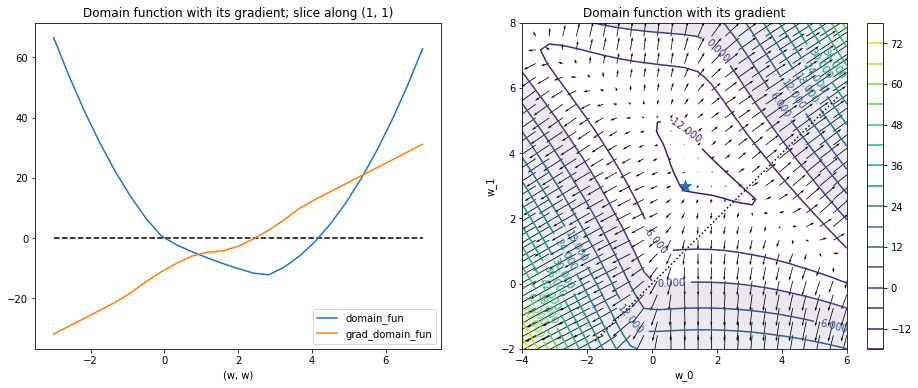

In [16]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(lin_w, [0 for x in lin_w], ls='--', c='k')
ax.plot(lin_w, domain1d, label='domain_fun')
ax.plot(lin_w, gradient1d, label='grad_domain_fun')
ax.set_xlabel(r'(w, w)')
ax.set_ylabel(r'')
ax.legend()
ax.set_title('Domain function with its gradient; slice along (1, 1)');

ax = fig.add_subplot(122)
# select those points from lin_w that are also in mesh_w:
lin_mesh = lin_w[[np.max([np.min(m) for m in mesh_w]) 
                  <= l <= np.min([np.max(m) for m in mesh_w]) for l in lin_w]]
ax.plot(lin_mesh, lin_mesh, ls=':', c='k')
cntr = ax.contour(*mesh_w, domain2d, levels=15)
fig.colorbar(cntr)
ax.clabel(cntr, inline=1, fontsize=10)
ax.contourf(*mesh_w, domain2d, levels=cntr.levels[cntr.levels >= 0], 
            cmap=cntr.cmap, alpha=0.1)
ax.quiver(*mesh_w, *gradient2d, scale=150)
ax.scatter(*t, marker='*', s=150)
ax.set_xlabel(r'w_0')
ax.set_ylabel(r'w_1')
ax.set_title('Domain function with its gradient');

The right plot shows the contour plot of the domain function (boundary at 0, with shaded region being outside of the domain). Further, it shows the true value of the slope vector that we want to estimate (blue star). The vector field is the gradient of the domain function.

Now, let us implement the projected gradient descent algorithm

In [17]:
def project_to_domain(w):
    """ return z in D_r for which |z - w| is minimal
    """
    if in_domain(w):
        return w
    
    def norm(tau):
        v = ellipsoid(w, tau)
        if v is not None:
            return np.linalg.norm(v - w)
        else:
            return None
        
    tau = binary_search(norm, left=-1, right=1e3)
    return ellipsoid(w, tau)

def binary_search(fun, left, right, tol=1e-3):
    """ Binary search optimization.
        return lowest value beween left and right 
            for which fun is not None.
    """
    assert left < right
    assert fun(right) is not None
    
    if fun(left) is not None:
        return left
    if right - left < tol:
        return right
    mid = (left + right) / 2
    if fun(mid) is not None:
        return binary_search(fun, left, mid, tol=tol)
    else:
        return binary_search(fun, mid, right, tol=tol)

def ellipsoid(w, tau):
    """ return z for which |z - w| <= tau 
    """
    return ellipsoid_method(w, tau, separation_oracle)

def separation_oracle(u):
    """ Computing the gradient of the domain_fun is
        equivalent to equation (16) of the article.
        
        return True if u is in D_r
        return g for which {z | g * (z - u) == 0} is a
            separating hyperplane between u and D_r
    """
    return in_domain(u), grad_domain_fun(u)

def ellipsoid_method(x, tau, H):
    """ Given ellipsoid {z | (z - x)**2 <= tau},
        and separation oracle H between x and D_r,
        construct a sequence of ellipsoids of decreasing volume
        {z | (z - x[k])**2 <= P[k]}, P[k+1] < P[k], 
        that finds a x[k] in D_r for high enough k, if it exists.
        
        return x[k] or None
    """
    if tau < 0:
        return None
    
    n = n_features
    eps = 1e-3  # lower bound on volume of space of feasible solutions
    P = tau * np.eye(n)  # initialization
    g = 1e10 * one  # initialization to enter loop
    while np.sqrt(np.matmul(g.T, np.matmul(P, g))) > eps:
        # while feasible solution space not empty
        is_feasible, g = H(x)
        if is_feasible:
            return x
        else:
            g_norm = g / np.sqrt(np.matmul(g.T, np.matmul(P, g)))
            x = x - 1/(n + 1) * np.matmul(P, g_norm)
            P = P + 2/(n + 1) * np.outer(g_norm, g_norm.T)
            P *= 1 - 1/n**2
    return None

def gradient_estimation(x, w, y):
    """ return random sample that estimates gradient of log-likelihood
    """
    in_truncated_set = False
    while not in_truncated_set:
        sample = np.random.randint(len(x_trunc))
        u = x_trunc[sample]
        z = np.random.normal(np.matmul(w.T, u), 1)
        in_truncated_set = membership(z)
    return (y * x - z * u)

def PSGD(data, n_iter, l_rate, init=one):
    w = [project_to_domain(init)]
    for i in range(1, n_iter+1):
        sample = np.random.randint(len(data))
        x, y = data[sample, :-1], data[sample, -1]
        v = gradient_estimation(x, w[i-1], y)
        r = w[i-1] + l_rate / np.sqrt(i) * v
        r_proj = project_to_domain(r)
        w.append(r_proj)
        print(f'{i}/{n_iter}: projected slope = {r_proj}, '
              f'domain_fun: {domain_fun(r)}', end='\r')
    return w

With all that set up, we can apply the projected stochastic gradient descent to our truncated data:

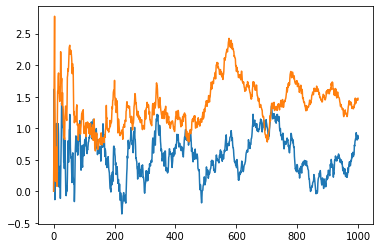

In [18]:
slope = PSGD(truncated_data, n_iter=1000, l_rate=1, init=np.array([0, 0]))
plt.plot(slope);

## Convergence analysis

The gradient estimation for the gradient descent approximates the gradient at current slope value $w$ by sampling the truncated data. Given a sample $(x_{\rm trunc}, y_{\rm trunc})$, the gradient is estimated by $\delta_w = y_{\rm trunc} x_{\rm trunc} - z\, u$, where $u$ is another random sample from the truncated data, and $z = w\cdot u + \epsilon$.

We can compute the gradient vector at each $w$ by averaged sampling of the gradient estimations and thus obtain the gradient vector field.

In [19]:
def grad_sgd(w):
    samples = np.random.randint(n_samples_trunc, size=50)
    x, y = x_trunc[samples], y_trunc[samples]
    gradient_est = [gradient_estimation(x_trunc[s], w, y_trunc[s]) for s in samples]
    return np.mean(gradient_est, axis=0)

Computing the vector field will take a few moments ... 

In [20]:
# np.transpose exchanges x and y, but we apply np.transpose again for plotting
gradient_sgd = np.transpose([[grad_sgd(w) for w in slice] 
                             for slice in np.transpose(mesh_w)])

Let's check how the solution above converged by adding it to the domain contour plot:

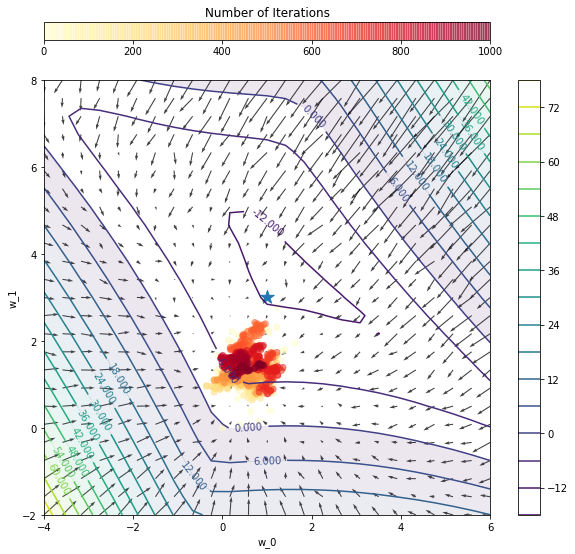

In [21]:
color = list(range(len(slope)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cntr = ax.contour(*mesh_w, domain2d, levels=15)
ax.quiver(*mesh_w, *gradient_sgd, scale=50, alpha=0.75)
ax.set_xlabel(r'w_0')
ax.set_ylabel(r'w_1')
fig.colorbar(cntr)
ax.clabel(cntr, inline=1, fontsize=10)
ax.contourf(*mesh_w, domain2d, levels=cntr.levels[cntr.levels >= 0], 
            cmap=cntr.cmap, alpha=0.1)
sctr = ax.scatter(*np.transpose(slope), c=color, cmap='YlOrRd', alpha=0.5)
cbax = fig.add_axes([0.125, 0.95, 0.62, 0.03])  # [left, bottom, width, height]
bar = fig.colorbar(sctr, cax=cbax, orientation='horizontal')
bar.ax.set_title('Number of Iterations')
ax.scatter(*t, marker='*', s=200);

This plot shows the contours of the domain function, this time with the expectation of the gradient vector field used for the SGD. The true value is marked as blue star. 

Now, we can compare again against our data and see how we did:

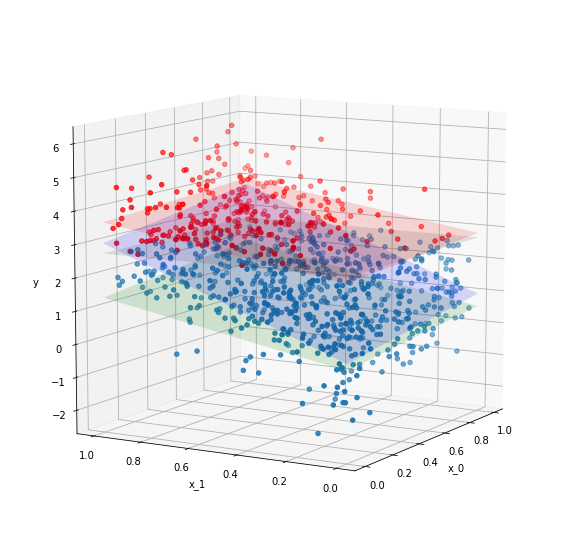

In [22]:
mean_slope = np.mean(slope, axis=0)
psgd_surf = np.transpose([[np.matmul(mean_slope.T, x) for x in slice] 
                          for slice in np.transpose(mesh_x)])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.plot_surface(*mesh_x, reg_surf, color='b', alpha=0.15)
ax.plot_surface(*mesh_x, reg_cut_surf, color='r', alpha=0.15)
ax.plot_surface(*mesh_x, psgd_surf, color='g', alpha=0.15)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y')
ax.view_init(10, -150)

The End.